In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
!python --version

Python 3.11.11


In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim

# Dataset

In [5]:
from library.dataset import get_pytorch_datataset, BATCH_SIZE

df_returns_real, dataset, dataloader, N_ASSETS, WINDOW_SIZE = get_pytorch_datataset()

print(f'\nDataset length: {len(dataset)}')
print(f'Number of assets: {N_ASSETS}')
sample_batch = next(iter(dataloader))
assert sample_batch.size() == (BATCH_SIZE, N_ASSETS, WINDOW_SIZE)
print(f'Sample batch: {sample_batch.size()}')

Chosen tickers: ['SBER', 'LKOH', 'SBERP', 'VTBR', 'MOEX']
Length before dropping NaNs: 2989
Length after dropping NaNs: 2959

Dataset length: 2833
Number of assets: 5
Sample batch: torch.Size([256, 5, 126])


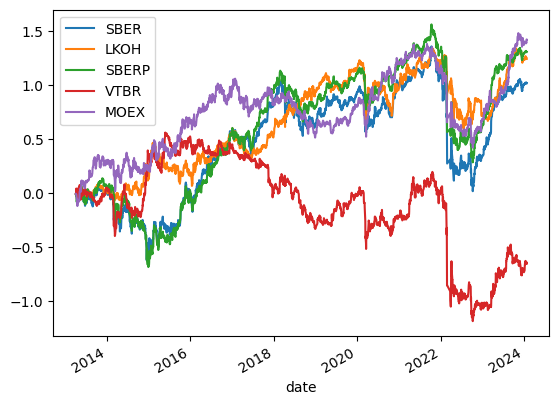

In [6]:
df_returns_real[:-252].cumsum().plot()
plt.show()

In [7]:
df_returns_real=df_returns_real[:-252]

# GAN


In [8]:
from library.constants import DEVICE

print(f'Use device: {DEVICE}')

Use device: cpu


In [9]:
from library.gan import Discriminator, Generator

assert Discriminator()(next(iter(dataloader))).size() == (BATCH_SIZE,)
assert Generator()(Generator.get_noise(BATCH_SIZE)).size() == next(iter(dataloader)).size()

/Users/nikolajgudkov/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


## Train

50 epochs train time: 249.9s. Estimated train time: 0.0m
Fake std: [0.04249968 0.02806976 0.04024073 0.04249209 0.02527285].
Real std: [0.02281783 0.01912733 0.02135713 0.02241513 0.01868306]
Fake correlation: 0.9826005774629124. Real correlation: 0.9197653587073278


/Users/nikolajgudkov/Desktop/курсач/максим/research/library/gan_train_loop.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
/Users/nikolajgudkov/Desktop/курсач/максим/research/library/gan_train_loop.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


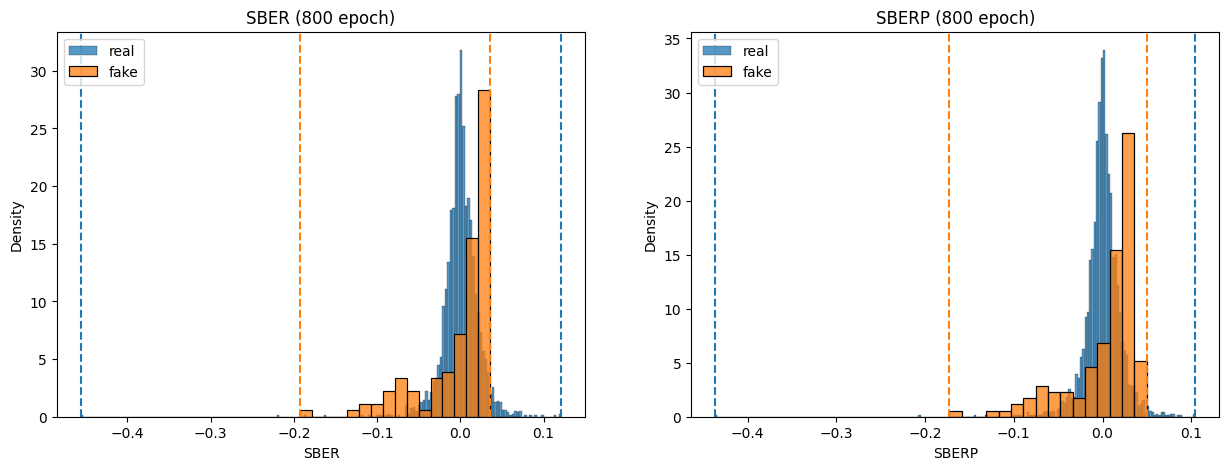

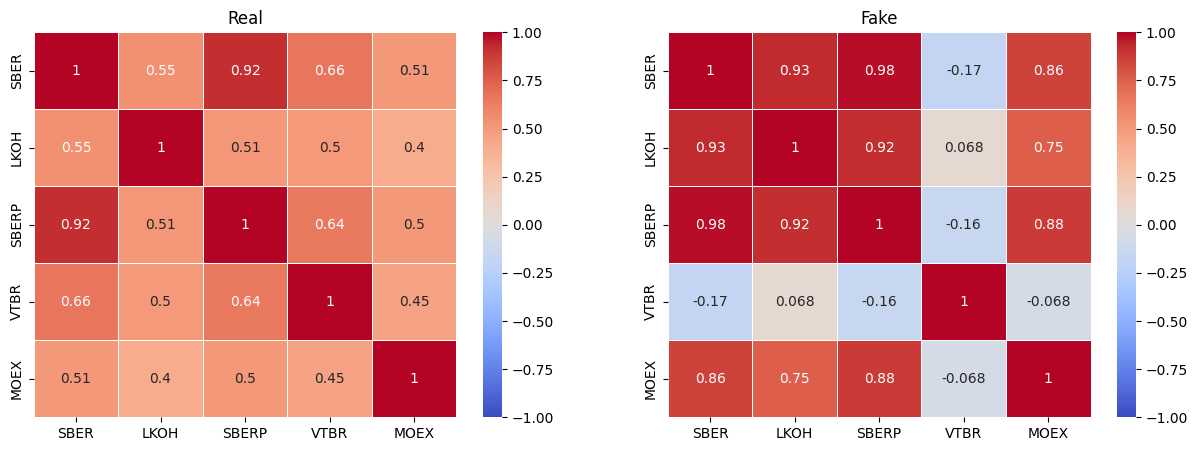

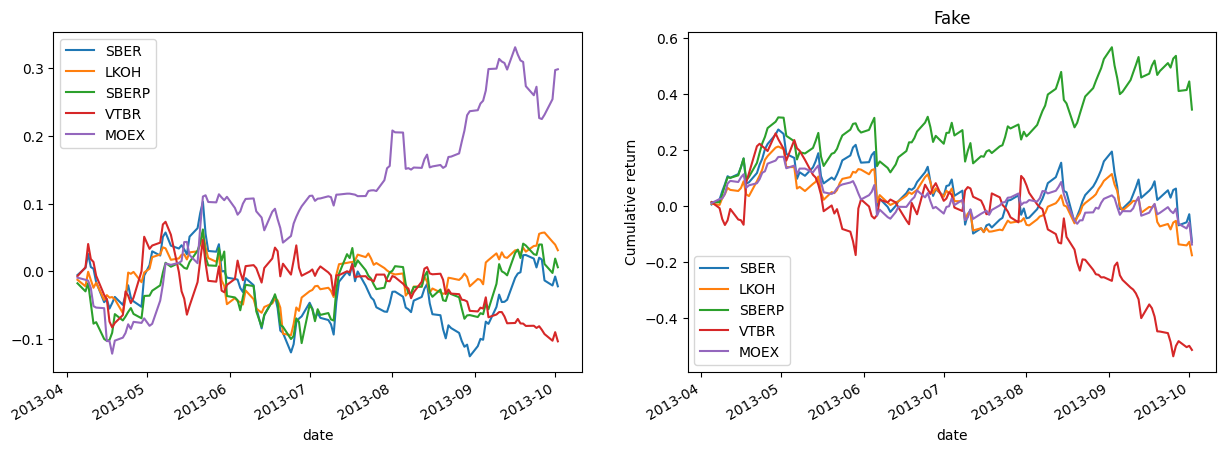

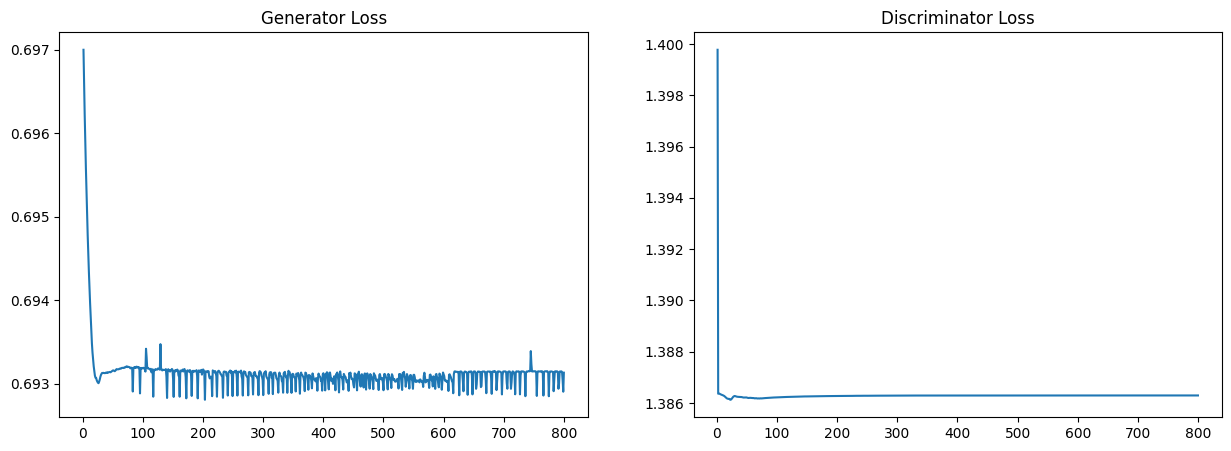

In [18]:
from library.gan_train_loop import train_gan

N_EPOCHS = 800
LOG_FREQUENCY = 50
SAVE_FREQUENCY = 200

# Define generator and discriminator
discriminator = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)

# Define the optimizers for generator and discriminator
LR = 0.0002
generator_optimizer = optim.RMSprop(generator.parameters(), lr=LR)
discriminator_optimizer = optim.RMSprop(discriminator.parameters(), lr=LR)

# Train GAN
discriminator_losses, generator_losses = train_gan(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader, df_returns_real, n_epochs=N_EPOCHS, log_frequency=LOG_FREQUENCY, save_frequency=SAVE_FREQUENCY, model_prefix='TCN')

# Generation

## Generate random history

In [15]:
from library.gan_train_loop import load_gan

generator = Generator().to(DEVICE)
load_gan('TCN', generator, epoch=50)

Load 50 epoch checkpoint


In [16]:
from library.generation import generate_fake_returns

df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)

## Plot cumulative real and fake returns

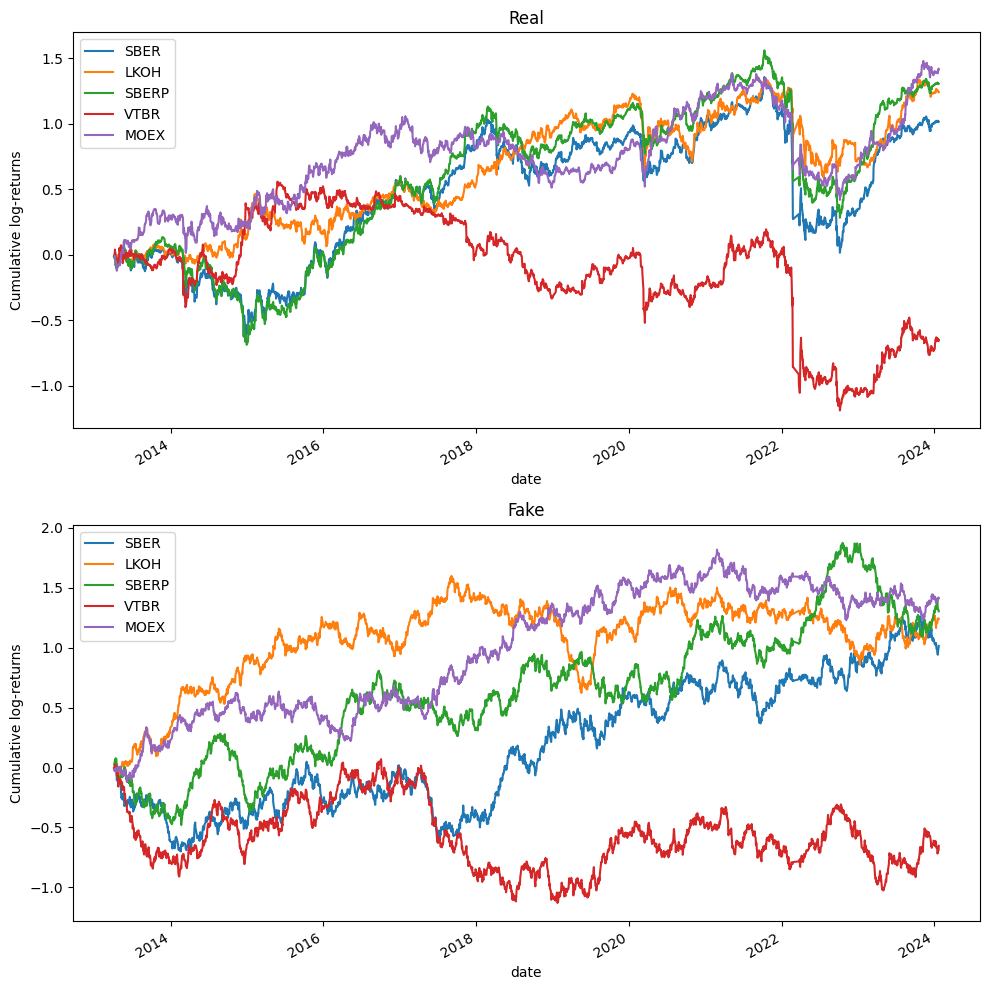

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

plt.subplot(2, 1, 1)

df_returns_real.cumsum().plot(ax=ax1)
plt.title('Real')
plt.ylabel('Cumulative log-returns')

plt.subplot(2, 1, 2)
df_returns_fake.cumsum().plot(ax=ax2)
plt.title('Fake')
plt.ylabel('Cumulative log-returns')
plt.tight_layout()

plt.show()

## Plot correlation matrix for real and fake returns

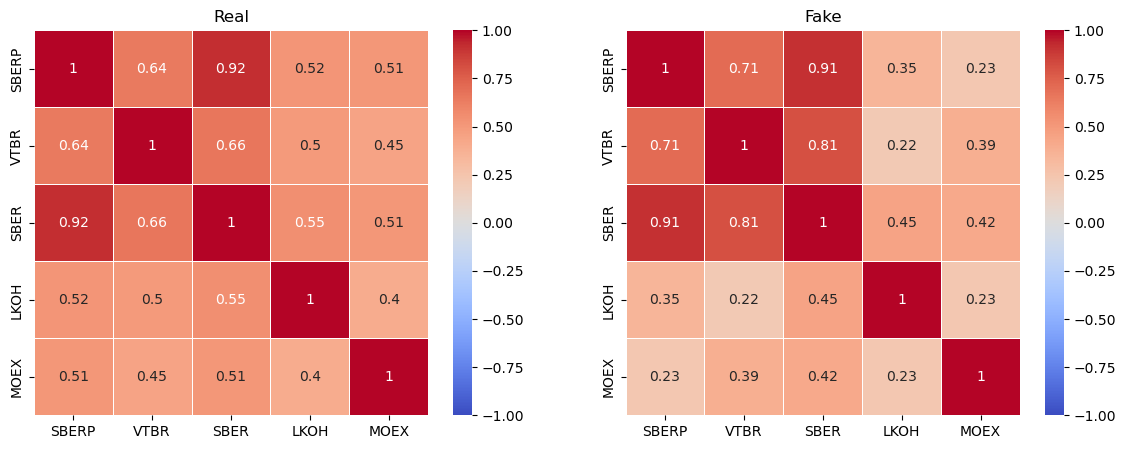

In [195]:
from library.correlations import plot_correlation_matrix

plt.subplots(1, 2, figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_correlation_matrix(df_returns_real.corr())
plt.title('Real')

plt.subplot(1, 2, 2)
plot_correlation_matrix(df_returns_fake.corr())
plt.title('Fake')

plt.show()

# Plot returns distribution

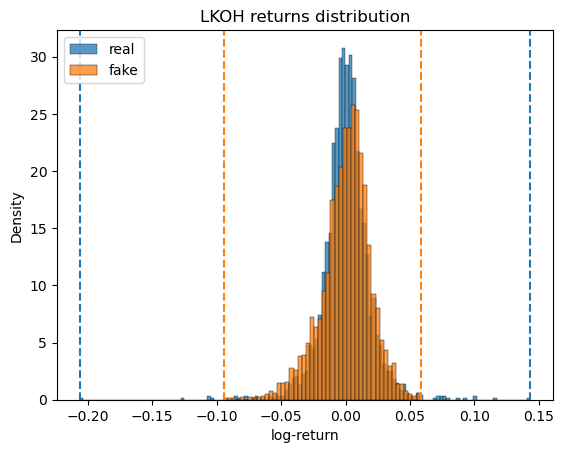

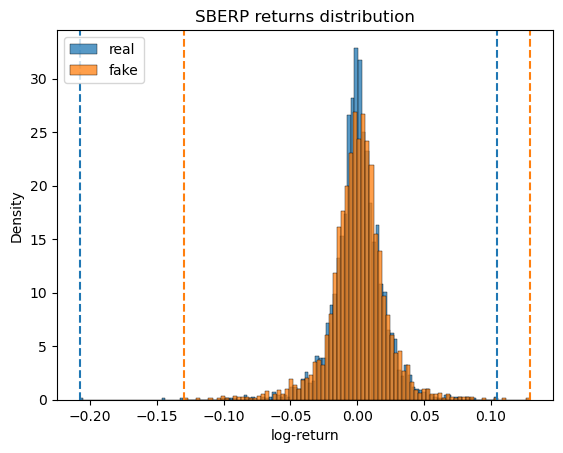

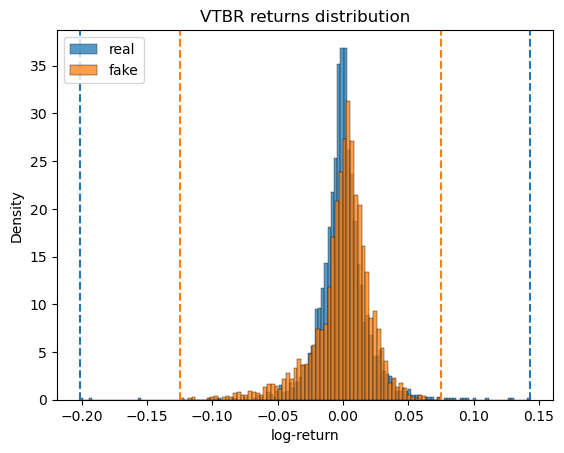

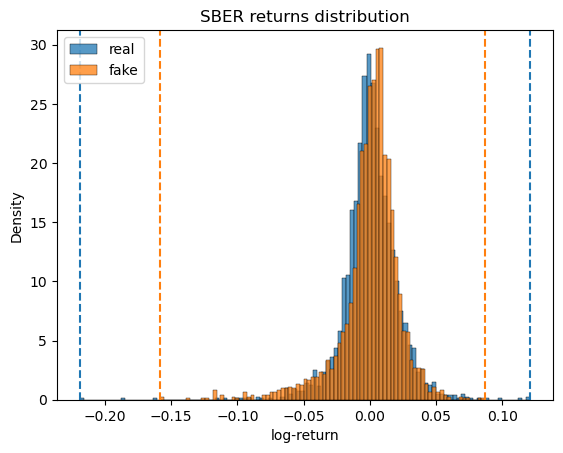

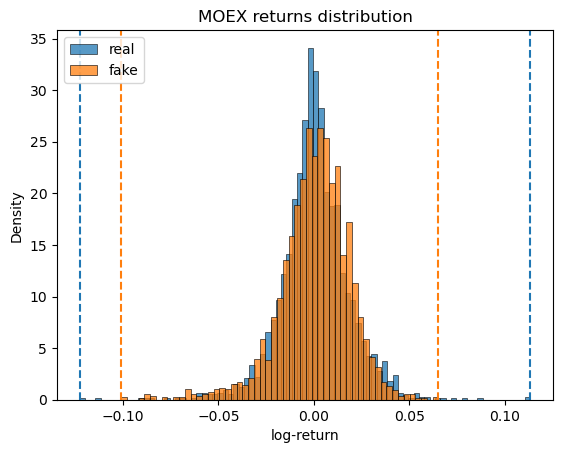

In [185]:
tmp_df_returns_real = df_returns_real[df_returns_real.sum(axis=1) != df_returns_real.sum(axis=1).min()]

for col in df_returns_real.columns:
    # Plot returns distributions
    sns.histplot(tmp_df_returns_real[col], stat='density', label='real')
    sns.histplot(df_returns_fake[col], stat='density', label='fake')

    # Plot real returns bounds
    plt.axvline(tmp_df_returns_real[col].min(), linestyle='dashed', color='C0')
    plt.axvline(tmp_df_returns_real[col].max(), linestyle='dashed', color='C0')

    # Plot fake returns bounds
    plt.axvline(df_returns_fake[col].min(), linestyle='dashed', color='C1')
    plt.axvline(df_returns_fake[col].max(), linestyle='dashed', color='C1')

    plt.xlabel('log-return')
    plt.legend(loc='upper left')
    plt.title(f'{col} returns distribution')
    plt.show()